### Knowledge Graph With Langchain


### Problem:
Build an Information Retreival system from a Given Text using LLM
### Solution pipeline:

Step 1. Convert Text into Documents.
  
  Suggestion: Document class from the langchain_core.documents module.

  The Document class is typically used to represent a piece of text or content, often as part of a larger framework for language processing or information retrieval. In the context of the LangChain library, the Document class is used to encapsulate text data along with its metadata, making it easier to manipulate, analyze, and transform the text for various language processing tasks.

Step 2. Convert Documents into Graph Documents.

  Suggestion: LLMGraphTransformer class from the langchain_experimental.graph_transformers module.

  Loading graph documents into a Neo4j database for querying.


Step 3. Load Graph Documents into Neo4j.

Step 4. Retrieve information from Neo4j without writing Cypher Queries explicitly.

  Suggestion: GraphCypherQAChain class from langchain.chains module.

  The primary function of the GraphCypherQAChain is to translate natural language questions into Cypher queries. This allows users to interact with graph databases using conversational language without needing to know Cypher syntax.



In [1]:
## Install Libraries required.
!pip install --upgrade --quiet langchain langchain-community langchain-groq neo4j
!pip install langchain-community langchain-core
!pip install --upgrade --quiet langchain_experimental

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 990.6/990.6 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.6/293.6 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.5/103.5 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 379.9/379.9 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.1/140.1 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.

In [2]:
##Load Libraries required.
# from langchain.docstore.document import Document
from langchain_community.graphs import Neo4jGraph
from langchain.chains import GraphCypherQAChain
# from langchain.chains.question_answering import load_qa_chain
from langchain_groq import ChatGroq
from langchain_core.documents import Document
from langchain_experimental.graph_transformers import LLMGraphTransformer
from neo4j import GraphDatabase
import os


In [3]:
##Graph db Configurations
NEO4J_URI="neo4j+s://0edd137b.databases.neo4j.io"
NEO4J_USERNAME="neo4j"
NEO4J_PASSWORD="*****"


In [4]:
os.environ["NEO4J_URI"] = NEO4J_URI
os.environ["NEO4J_USERNAME"] = NEO4J_USERNAME
os.environ["NEO4J_PASSWORD"] = NEO4J_PASSWORD
groq_api_key = "*****"

In [5]:
#Using Groq to get LLM models.
llm = ChatGroq(groq_api_key=groq_api_key, model_name="Gemma2-9b-It")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x78e9077b5f00>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x78e9077b5240>, model_name='Gemma2-9b-It', groq_api_key=SecretStr('**********'))

In [6]:
# Sample text
text = """
Avul Pakir Jainulabdeen Abdul Kalam BR was an Indian aerospace scientist and statesman who served as the 11th president of India from 2002 to 2007.
Born and raised in a Muslim family in Rameswaram, Tamil Nadu, he studied physics and aerospace engineering.
He spent the next four decades as a scientist and science administrator, mainly at the Defence Research and Development Organisation (DRDO) and Indian Space Research Organisation (ISRO) and was intimately involved in India's civilian space programme and military missile development efforts.
He thus came to be known as the Missile Man of India for his work on the development of ballistic missile and launch vehicle technology.
He also played a pivotal organisational, technical, and political role in India's Pokhran-II nuclear tests in 1998, the first since the original nuclear test by India in 1974.

Kalam was elected as the 11th president of India in 2002 with the support of both the ruling Bharatiya Janata Party and the then-opposition Indian National Congress. Widely referred to as the "People's President",[6] he returned to his civilian life of education, writing and public service after a single term. He was a recipient of several prestigious awards, including the Bharat Ratna, India's highest civilian honour.
"""

In [7]:
## Step 1. Convert Text into Documents.
documents = [Document(page_content=text)]

## Step 2. Convert Documents into Graph Documents.
llm_transformer = LLMGraphTransformer(llm=llm)
graph_documents = llm_transformer.convert_to_graph_documents(documents)
graph_documents

[GraphDocument(nodes=[Node(id='Avul Pakir Jainulabdeen Abdul Kalam Br', type='Person'), Node(id='Defence Research And Development Organisation (Drdo)', type='Organization'), Node(id='Indian Space Research Organisation (Isro)', type='Organization'), Node(id='Bharatiya Janata Party', type='Organization'), Node(id='Indian National Congress', type='Organization'), Node(id='Rameswaram', type='Place'), Node(id='Tamil Nadu', type='Place'), Node(id='India', type='Country'), Node(id='Pokhran-Ii', type='Event')], relationships=[Relationship(source=Node(id='Avul Pakir Jainulabdeen Abdul Kalam Br', type='Person'), target=Node(id='Rameswaram', type='Place'), type='BORN_IN'), Relationship(source=Node(id='Avul Pakir Jainulabdeen Abdul Kalam Br', type='Person'), target=Node(id='Tamil Nadu', type='Place'), type='RAISED_IN'), Relationship(source=Node(id='Avul Pakir Jainulabdeen Abdul Kalam Br', type='Person'), target=Node(id='Defence Research And Development Organisation (Drdo)', type='Organization'), t

In [9]:
def convert_graph_documents_to_dict(graph_documents):
    """
    Convert the graph documents into a dictionary format suitable for loading into Neo4j
    """
    dict_list = []

    for doc in graph_documents:
        # Extract nodes and relationships from each GraphDocument
        nodes = [{'id': node.id, 'type': node.type} for node in doc.nodes]
        relationships = [
            {
                'source': rel.source.id,
                'target': rel.target.id,
                'type': rel.type
            }
            for rel in doc.relationships
        ]

        # Append to dictionary list
        dict_list.append({
            'nodes': nodes,
            'relationships': relationships
        })

    return dict_list

In [10]:
graph_documents_dict = convert_graph_documents_to_dict(graph_documents)
graph_documents_dict

[{'nodes': [{'id': 'Avul Pakir Jainulabdeen Abdul Kalam Br', 'type': 'Person'},
   {'id': 'Defence Research And Development Organisation (Drdo)',
    'type': 'Organization'},
   {'id': 'Indian Space Research Organisation (Isro)', 'type': 'Organization'},
   {'id': 'Bharatiya Janata Party', 'type': 'Organization'},
   {'id': 'Indian National Congress', 'type': 'Organization'},
   {'id': 'Rameswaram', 'type': 'Place'},
   {'id': 'Tamil Nadu', 'type': 'Place'},
   {'id': 'India', 'type': 'Country'},
   {'id': 'Pokhran-Ii', 'type': 'Event'}],
  'relationships': [{'source': 'Avul Pakir Jainulabdeen Abdul Kalam Br',
    'target': 'Rameswaram',
    'type': 'BORN_IN'},
   {'source': 'Avul Pakir Jainulabdeen Abdul Kalam Br',
    'target': 'Tamil Nadu',
    'type': 'RAISED_IN'},
   {'source': 'Avul Pakir Jainulabdeen Abdul Kalam Br',
    'target': 'Defence Research And Development Organisation (Drdo)',
    'type': 'WORKED_AT'},
   {'source': 'Avul Pakir Jainulabdeen Abdul Kalam Br',
    'target'

In [11]:
##Step 3. Load Graph Documents into Neo4j.
driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USERNAME, NEO4J_PASSWORD))

def load_graph_documents(driver, graph_documents):
    with driver.session() as session:
        for doc in graph_documents:
            # Ensure doc is a dictionary
            if isinstance(doc, dict):
                # Create nodes
                nodes = doc.get('nodes', [])
                for node in nodes:
                    if isinstance(node, dict):  # Ensure each node is a dictionary
                        session.run(
                            f"""
                            MERGE (n:{node.get('type')} {{name: $name}})
                            SET n += $properties
                            """,
                            name=node.get('id'),
                            properties={k: v for k, v in node.items() if k not in ['id', 'type']}
                        )
                # Create relationships
                relationships = doc.get('relationships', [])
                for rel in relationships:
                    if isinstance(rel, dict):  # Ensure each relationship is a dictionary
                        session.run(
                            f"""
                            MATCH (a {{name: $source}})
                            MATCH (b {{name: $target}})
                            MERGE (a)-[r:{rel.get('type')}]->(b)
                            """,
                            source=rel.get('source'),
                            target=rel.get('target')
                        )



In [12]:
load_graph_documents(driver, graph_documents_dict)


The above step will generate the following Graph in Neo4j.

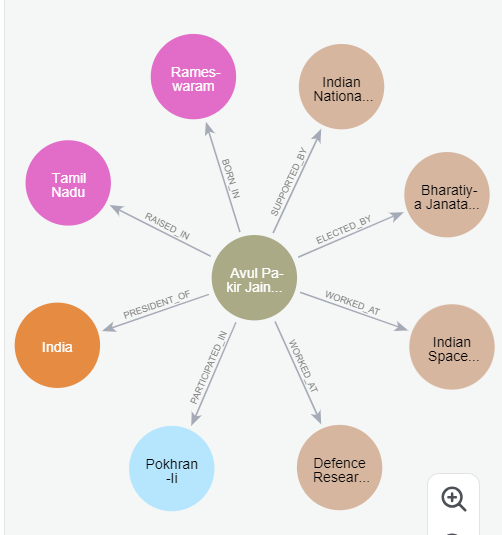

In [13]:
#Step 4. Retrieve information from Neo4j without writing Cypher Queries explicitly.

# Initialize Neo4jGraph object for graph operations
graph = Neo4jGraph(url=NEO4J_URI, username=NEO4J_USERNAME, password=NEO4J_PASSWORD)

# Initialize GraphCypherQAChain
chain = GraphCypherQAChain.from_llm(llm=llm, graph=graph, verbose=True)

# Define a sample question
question = "What was Avul Pakir Jainulabdeen Abdul Kalam Br involved in?"

# Get the response
response = chain.invoke({"query": question})
print(f"Question: {question}")
print(f"Response: {response}")



> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (p:Person {name: "Avul Pakir Jainulabdeen Abdul Kalam"})<-[:PARTICIPATED_IN]-(e:Event) RETURN e.name  

Full Context:
[]

> Finished chain.
Question: What was Avul Pakir Jainulabdeen Abdul Kalam Br involved in?
Response: {'query': 'What was Avul Pakir Jainulabdeen Abdul Kalam Br involved in?', 'result': "I don't know the answer. \n"}


In [14]:
# Initialize Neo4jGraph object for graph operations
graph = Neo4jGraph(url=NEO4J_URI, username=NEO4J_USERNAME, password=NEO4J_PASSWORD)

# Initialize GraphCypherQAChain
chain = GraphCypherQAChain.from_llm(llm=llm, graph=graph, verbose=True)

# Define a sample question
question = "What was Avul Pakir Jainulabdeen Abdul Kalam Br involved in?"

# Get the response
response = chain.invoke({"query": question})
print(f"Question: {question}")
print(f"Response: {response}")



> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (p:Person {name: "Avul Pakir Jainulabdeen Abdul Kalam Br"})-[r]->(e:Event)
RETURN e.name AS event_name
Full Context:
[{'event_name': 'Pokhran-Ii'}]

> Finished chain.
Question: What was Avul Pakir Jainulabdeen Abdul Kalam Br involved in?
Response: {'query': 'What was Avul Pakir Jainulabdeen Abdul Kalam Br involved in?', 'result': 'Avul Pakir Jainulabdeen Abdul Kalam was involved in Pokhran-Ii.  \n'}


In [15]:
# Define a sample question
question = "where was Avul Pakir Jainulabdeen Abdul Kalam Br worked at?"

# Get the response
response = chain.invoke({"query": question})
print(f"Question: {question}")
print(f"Response: {response}")



> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (p:Person {name: "Avul Pakir Jainulabdeen Abdul Kalam"})-[:WORKED_AT]->(o:Organization) RETURN o.name 

Full Context:
[]

> Finished chain.
Question: where was Avul Pakir Jainulabdeen Abdul Kalam Br worked at?
Response: {'query': 'where was Avul Pakir Jainulabdeen Abdul Kalam Br worked at?', 'result': "I don't know the answer. \n"}
